In [1]:
# Mitchell Schiworski, Jan 2019
#code to test the function that will set up and run the sampler for a given location

import numpy as np
import bilby
import gwinc
import matplotlib.pyplot as plt
import functools
import sys
import io
import cartopy.crs as ccrs
import scipy
import time
import logging

logging.disable(logging.INFO)
logging.disable(logging.WARNING)


13:46 bilby INFO    : Running bilby version: 0.3.3: (CLEAN) 5566d9d 2018-11-29 23:02:03 -0600
/home/mitchell/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#-------- Create NSNS signal --------
#(code taken from bibly injection example)

duration = 4.0
sampling_frequency = 2048.0
#NSNS signal at Zenith of Alice Springs, on Jan 1, 2019 12:00 PM.
injection_parameters = dict(
    mass_1=1.5, mass_2=1.3, chi_1=0.02, chi_2=0.02, luminosity_distance=50.,
    iota=0.4, psi=2.659, phase=1.3, geocent_time=1230379218,
    ra=4.48113285, dec=-0.413643033, lambda_1=400, lambda_2=450)

#------------------------------------- 
injection_parameters = dict(
    mass_1=10.5, mass_2=10.3, chi_1=0.02, chi_2=0.02, luminosity_distance=50.,
    iota=0.4, psi=2.659, phase=1.3, geocent_time=1126259642.413,
    ra=1.375, dec=-1.2108, lambda_1=400, lambda_2=450)
#------------------------------------

# Set the duration and sampling frequency of the data segment that we're going
# to inject the signal into. For the
# TaylorF2 waveform, we cut the signal close to the isco frequency
duration = 8
sampling_frequency = 2 * 1570.
start_time = injection_parameters['geocent_time'] + 2 - duration

# Fixed arguments passed into the source model. The analysis starts at 40 Hz.
waveform_arguments = dict(waveform_approximant='TaylorF2',
                          reference_frequency=50., minimum_frequency=40.0)

# Create the waveform_generator using a LAL Binary Neutron Star source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments)
    
    
#-------- Create prior for BNS ----

# Use delta functions about injected value for all but RA / Dec
priors = bilby.gw.prior.BNSPriorDict()
for variable in [    'mass_1', 'mass_2', 'chi_1', 'chi_2', 'luminosity_distance',
    'iota', 'psi', 'phase', 'geocent_time', 'lambda_1', 'lambda_2']:
    priors[variable] = injection_parameters[variable]    
    

/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: divide by zero encountered in true_divide
  z_prior.prob(x / aas)), aas) for x in xx]
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: invalid value encountered in multiply
  z_prior.prob(x / aas)), aas) for x in xx]


In [5]:
#create the psd for an A+ detector
max_frequency = 4
min_frequency = 0
frequencies = np.logspace(min_frequency,max_frequency,1000)

gwinc_detector = gwinc.load_ifo('A+')
gwinc_detector = gwinc.precompIFO(frequencies,gwinc_detector)
gwinc_noises = gwinc.noise_calc(frequencies,gwinc_detector)
Aplus_psd = gwinc_noises['Total']

#Create Interferometer List of existing detectors, and update them to have A+ psd
existing_ifos = bilby.gw.detector.InterferometerList(['H1','L1','V1'])
for interferometer in existing_ifos :
    interferometer.power_spectral_density = \
    bilby.gw.detector.PowerSpectralDensity(frequency_array=frequencies,psd_array=Aplus_psd)
    


    
    
def get_OZHF_detector_with_lat_long(lat,long) :
    #returns an interferometer object with OZHF psd at location passed into function
    
    #code taken from https://github.com/OZGrav/ozhf/blob/master/code/python/gwinc_and_bilby.ipynb
    # Create a detector with gwinc
    OZHF_freqs = frequencies
    OZHF_gwinc = gwinc.load_ifo('./ozhf.yaml')

    OZHF_gwinc.Infrastructure.Length = 4000
    OZHF_gwinc.Optics.Curvature.ETM  = OZHF_gwinc.Infrastructure.Length*0.6
    OZHF_gwinc.Optics.Curvature.ITM  = OZHF_gwinc.Infrastructure.Length*0.6

    # Build the actual model and compute the noises
    OZHF_gwinc = gwinc.precompIFO(OZHF_freqs, OZHF_gwinc)
    OZHF_gwinc_noises = gwinc.noise_calc(OZHF_freqs, OZHF_gwinc)
    OZHF_psd = OZHF_gwinc_noises['Total']
    OZHF = bilby.gw.detector.Interferometer(\
            power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=frequencies,psd_array=OZHF_psd),
            name='OZHF', length = OZHF_gwinc.Infrastructure.Length,
            minimum_frequency=min_frequency, maximum_frequency=max_frequency,
            latitude = lat, longitude = long,
            elevation = 0., xarm_azimuth=2., yarm_azimuth=125.)

    return OZHF
    
    
def run_sampler_with_lat_long(lat,long,plot_signal = False) :
    
    #create new detector network, ifos, which includes a new OZHF detector and the existing three detectors.
    ifos = existing_ifos.copy()
    ifos = []
    ifos.append(get_OZHF_detector_with_lat_long(lat,long))

    #inject the signal into the network
    

    for interferometer in ifos:
        interferometer.set_strain_data_from_zero_noise(
            sampling_frequency=sampling_frequency, duration=duration)
        print(interferometer.name)
        interferometer.inject_signal(
            parameters=injection_parameters, waveform_generator=waveform_generator)

        if plot_signal == True :
            signal = interferometer.get_detector_response(waveform_generator.frequency_domain_strain(),injection_parameters)
            interferometer.plot_data(signal=signal)
        
    #create the likelihood
    likelihood = bilby.gw.GravitationalWaveTransient(interferometers=ifos,waveform_generator=waveform_generator,priors=priors,\
                                                    time_marginalization=False, phase_marginalization=False, distance_marginalization=False)
    
    #start timer
    start_timer = time.time()
    
    result = bilby.run_sampler(likelihood=likelihood,priors=priors,injection_parameters=injection_parameters,npoints=10,)
    
    end_timer = time.time()
    print("Running the sampler for lat/long = %d.3/%d.3 took %d seconds" %(lat,long,end_timer - start_timer))
    
    return result, ifos
    
    
   
    
result, ifos = run_sampler_with_lat_long(-31.34,115.91,plot_signal=False)
    

OZHF


/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: divide by zero encountered in true_divide
  z_prior.prob(x / aas)), aas) for x in xx]
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: invalid value encountered in multiply
  z_prior.prob(x / aas)), aas) for x in xx]
 26| logz ratio=-0.055 +/-    nan | dlogz:  0.008 >  0.100/home/mitchell/anaconda3/lib/python3.6/site-packages/dynesty/sampler.py:220: RuntimeWarning: invalid value encountered in sqrt
  ('logzerr', np.sqrt(np.array(self.saved_logzvar))),



Running the sampler for lat/long = -31.3/115.3 took 0 seconds


/home/mitchell/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/home/mitchell/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1e-30, 1e-13)

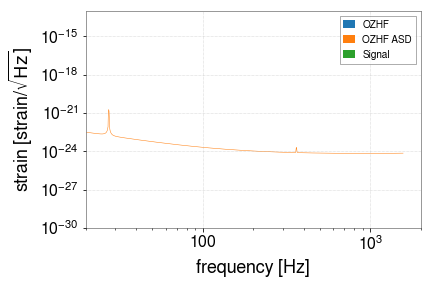

In [6]:
interferometer=ifos[0]
signal = interferometer.get_detector_response(waveform_generator.frequency_domain_strain(),injection_parameters)
interferometer.plot_data(signal=signal)
plt.ylim(1e-30,1e-13)

